# Notebook for comparing simulation outputs

## Summary
* [1. Read & Process simulation outputs](#t1)
* [2. Read forcings](#t2)
* [3. Compare ET fluxes](#t3)
* [4. Compare Water Table Depths](#t4)
* [5. Compare Water budgets](#t5)


## 1. Read & Process simulation outputs <a class="anchor" id="t1"></a>

In [1]:
import numpy as np
import os,glob,struct
import xarray as xr
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import datetime


from parflow import read_pfb, read_pfb_sequence, ParflowBinaryReader
from parflow import Run

In [2]:
def read_and_process_pf_outputs(wdir,date_start="2005-01-01"):
    # read header
    with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header
    print(h)
    
    # get z
    var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])
    var_dz_vec = var_dz[:,0,0]
    var_dz_vec = var_dz_vec[::-1]
    dz = var_dz_vec * h['dz']
    z = np.cumsum(dz) - var_dz_vec/2 
    
    # get pressure (pop(0) skips initial condition)
    files = np.sort(glob.glob(wdir+'*.press.*.pfb'))[1::]
    press = read_pfb_sequence(files)
    
    # get saturation
    files = np.sort(glob.glob(wdir+'*.satur.*.pfb'))[1::]
    satur = read_pfb_sequence(files)
    
    # get evaptranssum
    files = np.sort(glob.glob(wdir+'*.evaptranssum.*.pfb'))
    evaptranssum = read_pfb_sequence(files)
        
    # get overlandsum
    files = np.sort(glob.glob(wdir+'*.overlandsum.*.pfb'))
    overlandsum = read_pfb_sequence(files)
        
    # create dataset
    ds = xr.Dataset({"press": (("time","z","y"), press[:,::-1,:,0]),
                    "satur": (("time","z","y"), satur[:,::-1,:,0]),
                    "evaptranssum": (("time","z","y"), evaptranssum[:,::-1,:,0]),
                    "overlandsum":(("time","y"), overlandsum[:,0,:,0]),
                    'vdz': (("z","y"),var_dz[::-1,:,0])},
        coords={"x":np.arange(start = h['x'],stop = h['x']+h['nx']*h['dx'],step=h['dx']),
            "y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
            "z":-z, 
            "time": pd.date_range(date_start, periods=len(files)),
            "reference_time": pd.Timestamp(date_start)})

    # add WTD:
    ds = ds.assign(WTD = z[-1] - ds.press.isel(z=-1))

    # add auxiliary variables:
    ds = ds.assign(poro=(("z","y"),read_pfb(glob.glob(wdir+'*poro*.pfb')[0])[::-1,:,0]))
    ds = ds.assign(specstor=(("z","y"),read_pfb(glob.glob(wdir+'*specific*.pfb')[0])[::-1,:,0]))    

    # compute storage:
    ds = ds.assign(storage_cbyc=lambda x: h['dx']*h['dy']*h['dz']*x.satur*x.vdz*x.poro + \
                                        h['dx']*h['dy']*h['dz']*x.vdz*x.specstor*x.satur*x.press + \
                                        xr.where((x.z==x.z[0]) & (x.press>0),h['dx']*h['dy']*x.press,0))
    ds = ds.assign(storage=lambda x: x.storage_cbyc.sum(dim=('z')))

    ds = ds.assign(soil_moisture = lambda x: x.satur*x.poro)
    
    ds.press.attrs['units']='m'
    ds.satur.attrs['units']='m3/m3'
    ds.evaptranssum.attrs['units']='m3/PFtimestep'
    ds.overlandsum.attrs['units']='m3/PFtimestep' 
    ds.storage.attrs['units']='m3'
    ds.storage_cbyc.attrs['units']='m3'  
    ds.y.attrs['units']='meters'
    ds.z.attrs['units']='meters'
    return ds

In [3]:
root_dir = "/home/hectorb/PARFLOW/PROJECTS/test_cases/hillslope/ara_bele/cours2023/"
wdir = root_dir+'results_benchmark/'
#wdir ='/home/hectorb/PARFLOW/PROJECTS/Hillslope/bele_nalo_tests/simus/docker_test/'
with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header

In [4]:
ds1 = read_and_process_pf_outputs(wdir)

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 50, 'nz': 15, 'dx': 10.0, 'dy': 10.0, 'dz': 2.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


In [5]:
wdir2 = root_dir+'results_herb/'
ds2 = read_and_process_pf_outputs(wdir2)

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 50, 'nz': 15, 'dx': 10.0, 'dy': 10.0, 'dz': 2.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


In [6]:
def calculate_OVFLOW(width,manning,slope,h):
    """
    simple function which return the overland flux from one cell to another across one cell
    """
    return (width/manning)*(slope**0.5)*h**(5./3.)


def calculate_runoff_from_press(htop,slopex,slopey,dx,dy,m):
    """
    compute runoff at single location
    htop dim is time
    """
    Sy = np.abs(slopey)
    Sx = np.abs(slopex)
    return np.where(htop>0,np.abs(calculate_OVFLOW(dy,m,Sx,htop))+np.abs(calculate_OVFLOW(dx,m,Sy,htop)),0)

def read_clm_outputs(wdir,date_start="2005-01-01"):
    # read header
    with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header
    print(h)    
    
    # get z
    var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])
    var_dz_vec = var_dz[:,0,0]
    var_dz_vec = var_dz_vec[::-1]
    dz = var_dz_vec * h['dz']
    z = np.cumsum(dz) - var_dz_vec/2 
    
    files = np.sort(glob.glob(wdir+'*.clm_output.*.pfb'))
    clms = read_pfb_sequence(files)
    # create dataset
    ds = xr.Dataset({"lh_tot": (("time","y"), clms[:,0,:,0]),
                    "lwrad_out": (("time","y"), clms[:,1,:,0]),
                    "sh_tot": (("time","y"), clms[:,2,:,0]),
                    "soil_grnd": (("time","y"), clms[:,3,:,0]),
                    "evap_tot": (("time","y"), clms[:,4,:,0]*60*60),
                    "evap_grnd": (("time","y"), clms[:,5,:,0]*60*60),
                    "evap_soi": (("time","y"), clms[:,6,:,0]*60*60),
                    "evap_veg": (("time","y"), clms[:,7,:,0]*60*60),
                    "tran_veg": (("time","y"), clms[:,8,:,0]*60*60),
                    "infl": (("time","y"), clms[:,9,:,0]*60*60),
                    "swe_out": (("time","y"), clms[:,10,:,0]),
                    "t_grnd": (("time","y"), clms[:,11,:,0]),
                    "htop": (("time","y"), clms[:,12,:,0])},

        coords={
            "y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
                    "z":-z,
            "time": pd.date_range(date_start, periods=len(files),freq='1H'),
            "reference_time": pd.Timestamp(date_start)})

    ds = ds.assign(slopex=(("y"),read_pfb(glob.glob(wdir+'*slope_x*.pfb')[0])[0,:,0]))
    ds = ds.assign(slopey=(("y"),read_pfb(glob.glob(wdir+'*slope_y*.pfb')[0])[0,:,0]))

    ds.lh_tot.attrs['units']='$W/m^2$'
    ds.lwrad_out.attrs['units']='$W/m^2$'
    ds.sh_tot.attrs['units']='$W/m^2$'
    ds.soil_grnd.attrs['units']='$W/m^2$'
    ds.evap_tot.attrs['units']='mm/h'
    ds.evap_grnd.attrs['units']='mm/h'
    ds.evap_soi.attrs['units']='mm/h'
    ds.evap_veg.attrs['units']='mm/h'
    ds.tran_veg.attrs['units']='mm/h'
    ds.infl.attrs['units']='mm/h'
    ds.swe_out.attrs['units']='mm'
    ds.t_grnd.attrs['units']='K'
    ds.htop.attrs['units']='m'

    ds.y.attrs['units']='meters'
    return ds

In [7]:
dc1 = read_clm_outputs(wdir)
dc2 = read_clm_outputs(wdir2)

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 50, 'nz': 15, 'dx': 10.0, 'dy': 10.0, 'dz': 2.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 50, 'nz': 15, 'dx': 10.0, 'dy': 10.0, 'dz': 2.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


In [8]:
dc1 = dc1.assign(slopex=(("y"),read_pfb(glob.glob(wdir+'*slope_x*.pfb')[0])[0,:,0]))
dc1 = dc1.assign(slopey=(("y"),read_pfb(glob.glob(wdir+'*slope_y*.pfb')[0])[0,:,0]))
dc1 = dc1.assign(mask=(("z","y","x"),read_pfb(glob.glob(wdir+'*mask*.pfb')[0])))

In [9]:
dc2 = dc2.assign(slopex=(("y"),read_pfb(glob.glob(wdir2+'*slope_x*.pfb')[0])[0,:,0]))
dc2 = dc2.assign(slopey=(("y"),read_pfb(glob.glob(wdir2+'*slope_y*.pfb')[0])[0,:,0]))
dc2 = dc2.assign(mask=(("z","y","x"),read_pfb(glob.glob(wdir2+'*mask*.pfb')[0])))

In [10]:
hill = Run.from_definition(wdir+'hillslope.pfidb')

In [11]:
manning = hill.Mannings.Geom.domain.Value
dc1 = dc1.assign(Q=lambda x: ('time',calculate_runoff_from_press(x.htop.data[:,0],
                                                         x.slopex.data[0],
                                                         x.slopey.data[0],
                                                         10,10,manning)))
dc1.Q.attrs['units']='m3/CLMtimestep'

dc2 = dc2.assign(Q=lambda x: ('time',calculate_runoff_from_press(x.htop.data[:,0],
                                                         x.slopex.data[0],
                                                         x.slopey.data[0],
                                                         10,10,manning)))
dc2.Q.attrs['units']='m3/CLMtimestep'


/tmp/ipykernel_20345/810169220.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


## 2. Read forcings <a class="anchor" id="t2"></a>

In [12]:
""" Read Forcings: """
forcing_headers = {0:'SWin',1:'LWin',2:'P', 3: 'T', 4:'WindX', 5:'WindY',6:'Press', 7:'Hs'}
forc = pd.read_csv(glob.glob(os.sep.join([wdir,'*forc*txt*']))[0],header=None,sep='\t')
forc.rename(columns=forcing_headers,inplace=True)
forc.index=pd.date_range('1/1/2005 00:00:00', periods=len(forc), freq='30min')
P=forc['P']*30*60
forc

SWin   LWin    P       T  WindX  WindY    Press        Hs
2005-01-01 00:00:00  -3.0  331.3  0.0  291.75    1.0    0.0  96600.0  0.003954
2005-01-01 00:30:00  -3.0  328.8  0.0  290.75    0.6    0.0  96600.0  0.004013
2005-01-01 01:00:00  -2.8  326.5  0.0  290.25    0.6    0.0  96600.0  0.003976
2005-01-01 01:30:00  -2.0  326.0  0.0  289.95    0.8    0.0  96500.0  0.003880
2005-01-01 02:00:00  -2.6  325.4  0.0  289.65    0.9    0.0  96500.0  0.003818
...                   ...    ...  ...     ...    ...    ...      ...       ...
2015-12-31 21:30:00  -3.3  340.9  0.0  294.95    0.7    0.0  96510.0  0.004114
2015-12-31 22:00:00  -3.0  338.1  0.0  294.25    0.6    0.0  96510.0  0.004103
2015-12-31 22:30:00  -2.4  336.0  0.0  293.95    0.9    0.0  96510.0  0.004156
2015-12-31 23:00:00  -2.8  334.5  0.0  293.45    2.0    0.0  96500.0  0.004153
2015-12-31 23:30:00  -3.8  333.2  0.0  293.25    1.7    0.0  96500.0  0.004117

[192816 rows x 8 columns]

## 3. Compare ET fluxes <a class="anchor" id="t3"></a>

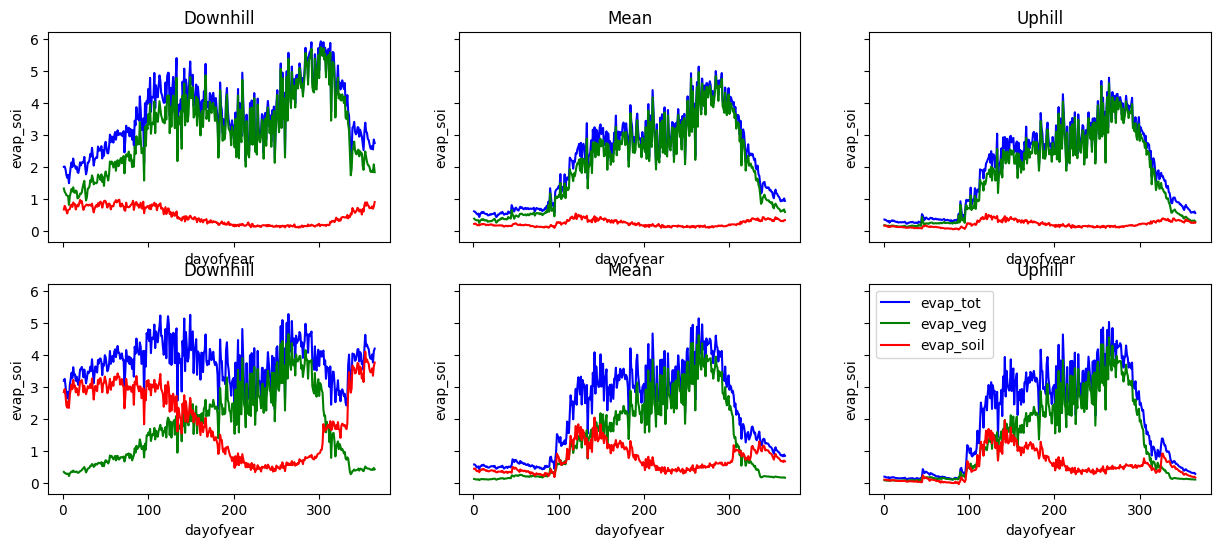

In [13]:
fig, ax = plt.subplots(2,3,sharex=True,sharey=True,figsize=(15,6))

#left: downhill
dc1.evap_tot.isel(y=0).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[0,0],label='evap_tot',color='b')
dc1.evap_veg.isel(y=0).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[0,0],label='evap_veg',color='g')
dc1.evap_soi.isel(y=0).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[0,0],label='evap_soil',color='r')
ax[0,0].title.set_text('Downhill')

#center: mean
dc1.evap_tot.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[0,1],label='evap_tot',color='b')
dc1.evap_veg.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[0,1],label='evap_veg',color='g')
dc1.evap_soi.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[0,1],label='evap_soil',color='r')
ax[0,1].title.set_text('Mean')


#right: uphill
dc1.evap_tot.isel(y=-1).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[0,2],label='evap_tot',color='b')
dc1.evap_veg.isel(y=-1).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[0,2],label='evap_veg',color='g')
dc1.evap_soi.isel(y=-1).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[0,2],label='evap_soil',color='r')
ax[0,2].title.set_text('Uphill')


#left: downhill
dc2.evap_tot.isel(y=0).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[1,0],label='evap_tot',color='b')
dc2.evap_veg.isel(y=0).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[1,0],label='evap_veg',color='g')
dc2.evap_soi.isel(y=0).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[1,0],label='evap_soil',color='r')
ax[1,0].title.set_text('Downhill')

#center: mean
dc2.evap_tot.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[1,1],label='evap_tot',color='b')
dc2.evap_veg.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[1,1],label='evap_veg',color='g')
dc2.evap_soi.mean(dim='y').resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[1,1],label='evap_soil',color='r')
ax[1,1].title.set_text('Mean')


#right: uphill
dc2.evap_tot.isel(y=-1).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[1,2],label='evap_tot',color='b')
dc2.evap_veg.isel(y=-1).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[1,2],label='evap_veg',color='g')
dc2.evap_soi.isel(y=-1).resample(time='D').sum().groupby('time.dayofyear').mean().plot(ax=ax[1,2],label='evap_soil',color='r')
ax[1,2].title.set_text('Uphill')

a = plt.gca()
a.legend()

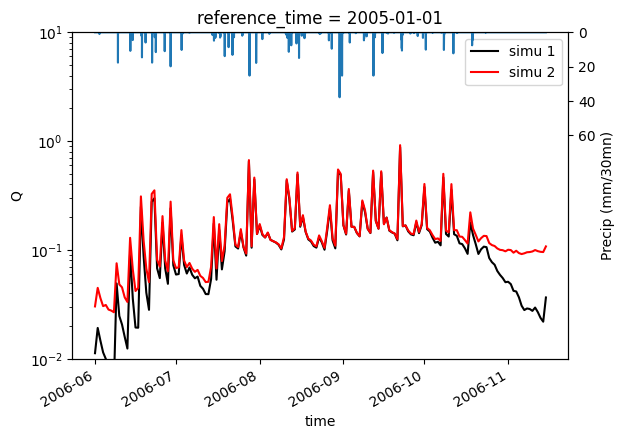

In [14]:
fig, ax = plt.subplots(1,1)
dc1.Q.sel(time=slice(datetime.datetime(2006,6,1),datetime.datetime(2006,11,15))).resample(time='D').mean().plot(yscale='log',ax=ax,color = 'k',label='simu 1')
dc2.Q.sel(time=slice(datetime.datetime(2006,6,1),datetime.datetime(2006,11,15))).resample(time='D').mean().plot(yscale='log',ax=ax,color = 'r',label='simu 2')

ax.legend()

ax.set_ylim([0.01,10])
p1=ax.twinx() #declare second axis for precipitation
P.loc[(P.index>datetime.datetime(2006,6,1)) & (P.index<datetime.datetime(2006,11,15))].plot(ax=p1,x_compat=True)
p1.set_ylim([0,190])
p1.set_yticks([0,20,40,60])
p1.set_ylabel('Precip (mm/30mn)')
p1.invert_yaxis() # invert precipitation axis

In [15]:
T1 = dc1.evap_veg.resample(time='D').sum().mean(dim='time')
T2 = dc2.evap_veg.resample(time='D').sum().mean(dim='time')

In [16]:
E1 = dc1.evap_soi.resample(time='D').sum().mean(dim='time')
E2 = dc2.evap_soi.resample(time='D').sum().mean(dim='time')

In [17]:
T_E1 = dc1.evap_veg.resample(time='D').sum().mean(dim='time') / dc1.evap_soi.resample(time='D').sum().mean(dim='time')
T_E2 = dc2.evap_veg.resample(time='D').sum().mean(dim='time') / dc2.evap_soi.resample(time='D').sum().mean(dim='time')

In [18]:
WTD_hillslope1=ds1.WTD.mean(dim='time')
WTD_hillslope2=ds2.WTD.mean(dim='time')

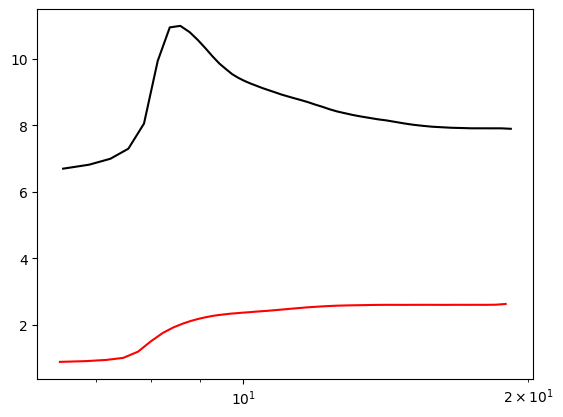

In [19]:
fig, ax = plt.subplots(1,1)

plt.semilogx(WTD_hillslope1.data,T_E1.data,color = 'k',label='simu 1')
plt.semilogx(WTD_hillslope2.data,T_E2.data,color = 'r',label='simu 2')


## 4. Compare Water Table Depths  <a class="anchor" id="t4"></a>

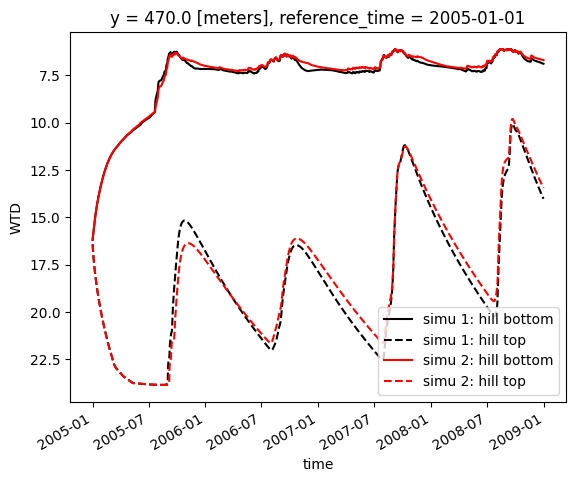

In [20]:
from matplotlib import pyplot as plt
ds1.WTD.isel(y=3).plot(label='simu 1: hill bottom',color='k')
ds1.WTD.isel(y=47).plot(label='simu 1: hill top',color='k',linestyle="--")
ds2.WTD.isel(y=3).plot(label='simu 2: hill bottom',color='r')
ds2.WTD.isel(y=47).plot(label='simu 2: hill top',color='r',linestyle="--")
plt.gca().legend()
plt.gca().invert_yaxis()

In [21]:
import hvplot.xarray

plot1 = (-ds1.WTD).hvplot.scatter(x='y',y='WTD',groupby='time',color='k')
plot2 = (-ds2.WTD).hvplot.scatter(x='y',y='WTD',groupby='time',color='r')

plot1 * plot2

:DynamicMap   [time]
   :Overlay
      .Scatter.I  :Scatter   [y]   (WTD)
      .Scatter.II :Scatter   [y]   (WTD)

## 5. Compare Water Budgets  <a class="anchor" id="t5"></a>

In [ ]:
from matplotlib import pyplot as plt
def plot_clustered_stacked(dfall, labels=None,  H="/", axe=None, **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    fig = plt.figure(figsize=(10,4))
    if not axe:
        axe = fig.add_subplot(111)

    for df in dfall : # for each data frame
        if isinstance(df, pd.DataFrame):
            axe = df.plot(kind="bar",
            linewidth=0,
            stacked=True,
            ax=axe,
            legend=False,
            grid=False,
            **kwargs)  # make bar plots
        else:
             axe = df.plot(kind="bar",
             linewidth=0,
             stacked=True,
             ax=axe,
             legend=False,
             grid=False,
	     color='b',
             **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe


In [23]:
tmp=xr.where(np.abs(ds1.z)<=np.abs(ds1.z[hill.Solver.CLM.RootZoneNZ-1]),ds1.evaptranssum*ds1.vdz,0).sum(dim="z").data
tmp=xr.where(ds1.z>=ds1.z[hill.Solver.CLM.RootZoneNZ-1],ds1.evaptranssum*ds1.vdz,0).sum(dim="z").data

ds1 = ds1.assign(ETsum1=(("time","y"),tmp))
ETsum1 = ds1.ETsum1.mean(dim=("y")).to_dataframe()['ETsum1']

tmp2=xr.where(np.abs(ds2.z)<=np.abs(ds2.z[hill.Solver.CLM.RootZoneNZ-1]),ds2.evaptranssum*ds2.vdz,0).sum(dim="z").data
tmp2=xr.where(ds2.z>=ds2.z[hill.Solver.CLM.RootZoneNZ-1],ds2.evaptranssum*ds2.vdz,0).sum(dim="z").data

ds2 = ds2.assign(ETsum2=(("time","y"),tmp2))
ETsum2 = ds2.ETsum2.mean(dim=("y")).to_dataframe()['ETsum2']

In [24]:
ETsum1 = ETsum1*1000/h['dx']/h['dy'] #m3 -> mm
ETsum2 = ETsum2*1000/h['dx']/h['dy'] #m3 -> mm

ET1 = -(ETsum1 -P.resample('D').sum())
ET2 = -(ETsum2 -P.resample('D').sum())

In [25]:
Q1 = ds1.overlandsum.isel(y=0).to_dataframe()['overlandsum']*1000/h['dx']/h['dy']/h['ny']

In [26]:
Q2 = ds2.overlandsum.isel(y=0).to_dataframe()['overlandsum']*1000/h['dx']/h['dy']/h['ny']

In [27]:
storage1 = ds1.storage.sum(dim='y').to_dataframe()['storage']*1000/h['dx']/h['dy']/h['ny']
storage1 = storage1 - storage1[0]
storage2 = ds2.storage.sum(dim='y').to_dataframe()['storage']*1000/h['dx']/h['dy']/h['ny']
storage2 = storage2 - storage2[0]

In [28]:
Budg1 = pd.DataFrame({'P':P.resample('Y').sum(),'ET':ET1.resample('Y').sum(),'Q':Q1.resample('Y').sum(),'WSC':np.nan})
Budg2 = pd.DataFrame({'P':P.resample('Y').sum(),'ET':ET2.resample('Y').sum(),'Q':Q2.resample('Y').sum(),'WSC':np.nan})

for i, y in enumerate(np.sort(storage1.index.year.unique())):
    if i ==0:
         Budg1['WSC'][Budg1.index.year==y] = storage1[storage1.index.year==y][-1]
         Budg2['WSC'][Budg2.index.year==y] = storage2[storage2.index.year==y][-1]
    else:
         Budg1['WSC'][Budg1.index.year==y] = storage1[storage1.index.year==y][-1] - storage1[storage1.index.year==y-1][-1] 
         Budg2['WSC'][Budg2.index.year==y] = storage2[storage2.index.year==y][-1] - storage2[storage2.index.year==y-1][-1] 
            
Budg1.index=Budg1.index.year
Budg2.index=Budg2.index.year

Budg1['closure'] = Budg1['P']- Budg1['ET']-Budg1['Q']-Budg1['WSC']
Budg2['closure'] = Budg2['P']- Budg2['ET']-Budg2['Q']-Budg2['WSC']


In [29]:
Budg1.dropna(inplace=True)
Budg2.dropna(inplace=True)
Budg1

P          ET           Q         WSC       closure
2005  1213.8912  792.347415   97.336934  324.311791 -1.049402e-01
2006   913.0176  799.691392  141.324479  -27.998272  3.297926e-07
2007  1213.8912  882.216494  235.732430   95.942275  4.738766e-07
2008  1210.6476  869.362682  312.131443   29.153474  4.687353e-07

In [30]:
Budg2

P          ET           Q         WSC       closure
2005  1213.8912  775.219390   98.804722  339.997080 -1.299911e-01
2006   913.0176  744.023633  171.830665   -2.836698  4.307864e-07
2007  1213.8912  867.779457  262.957682   83.154060  4.019150e-07
2008  1210.6476  839.306162  343.774374   27.567063  3.353426e-07

Text(0, 0.5, 'mm')

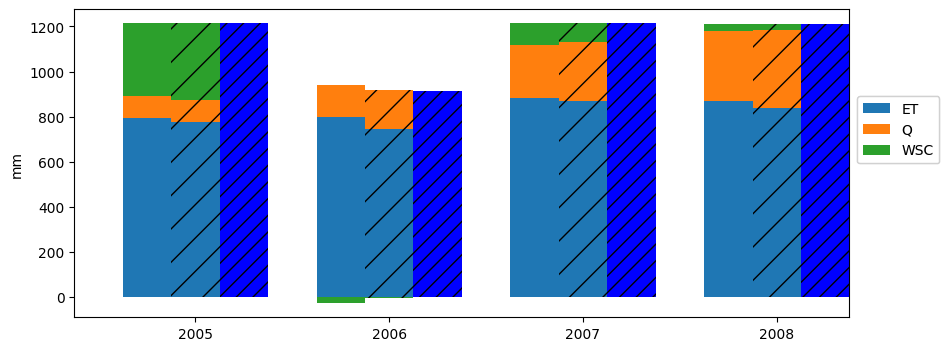

In [31]:
ax=plot_clustered_stacked([Budg1.loc[:,['ET','Q','WSC']],Budg2.loc[:,['ET','Q','WSC']],Budg1['P']])
ax.set_ylabel('mm')